In [0]:
!pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=c4c1752e93a4262d897b66a9649c56dc3abd28c9f1c890043a9ebf0d840406f3
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%cd "/content/drive/My Drive/MRNET for Knee Diagnosis"
import import_ipynb

/content/drive/.shortcut-targets-by-id/1XRl9VjI9EQqhwotbak7HD3HrmIXgeZA8/MRNET for Knee Diagnosis


In [0]:
import dataset_loader as loader
import models as models

importing Jupyter notebook from dataset_loader.ipynb
2.2.0
importing Jupyter notebook from models.ipynb
2.2.0


In [0]:
# Import the dependencies
import tensorflow as tf
from tensorflow import keras
import numpy as np
 
import os
 
# import sklearn
# from sklearn.metrics import confusion_matrix
 
import matplotlib as mpl
import matplotlib.pyplot as plt
 
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
 
#2.2.0
print(tf.__version__)

2.2.0


In [0]:
# class to train the MRNet models
# and generate the metrics plots
class Trainer():
    #model : the MENet model to be trained.
    #dataLoader : the data loader to generate the dataset (train, validation, test).
    #check_point_path : the path of the dirctory to save weights of models.
  def __init__(self, model, dataLoader, check_point_path):
    self.model = model
    self.dataLoader = dataLoader
    self.check_point_path = check_point_path
    self.train_history = None                                  # define the history of training process
    self.callbacks = [                                         # define the callbacks
      keras.callbacks.ReduceLROnPlateau(                       # callback to reduce learning rate
          monitor='val_loss',
          factor = 0.1,
          patience=3,
          verbose=1,
          min_lr=1e-5
      ),
      keras.callbacks.EarlyStopping(                          # callback to stop training if no improvement in validation_loss.
        monitor='val_loss', 
        verbose=1,
        patience= 5,
        restore_best_weights=True
        ),
      keras.callbacks.ModelCheckpoint(                      # callback to save the best model if no improvement in validation_AUC.
        monitor='val_auc',
        filepath=check_point_path,
        save_best_only=True,
        mode= 'max',
        verbose=1
        )
    ]
  # compile the MRNet model with optimizer, loss and metrics.
  def compile(self, learning_rate= 0.001):
    optimizer = keras.optimizers.Adam(learning_rate= learning_rate) # define the optimizer
    loss = keras.losses.BinaryCrossentropy()               # define the loss function
    metrics = [                                            # define the metrics to evaluate the model
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
    ]
    self.model.compile(optimizer= optimizer, loss= loss, metrics= metrics)
 
  # train the MRNet model with train dataset and validate it with validation dataset.
  def fit(self, epochs= 25):
    self.train_history = self.model.fit(self.dataLoader.get_train_generator(),
                                  epochs= epochs,       
                                  validation_data= self.dataLoader.get_valid_generator(), 
                                  callbacks= self.callbacks,
                                  class_weight = self.dataLoader.get_class_weight(),
                                  workers= 6)
  # evaluate the trained model with test dataset.
  def evaluate(self):
    evaluate_results = self.model.evaluate(self.dataLoader.get_test_generator(),
                                                workers= 6)
    for name, value in zip(self.model.metrics_names, evaluate_results):
        print(name, ': ', value)
 
  # plot the plots of metrices.
  def plot_metrics(self):
 
    metrics_name =  ['loss', 'auc', 'precision', 'recall']
 
    for n, metric in enumerate(metrics_name):
      name = metric.replace("_"," ").capitalize()
      plt.subplot(2,2,n+1)
      plt.plot(self.train_history.epoch,  self.train_history.history[metric], color=colors[0], label='Train')
      plt.plot(self.train_history.epoch, self.train_history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
      plt.xlabel('Epoch')
      plt.ylabel(name)
      if metric == 'loss':
        plt.ylim([0, plt.ylim()[1]])
      else:
        plt.ylim([0,1])
 
      plt.legend()

In [0]:
root_dir = "/content/drive/My Drive/MRNET for Knee Diagnosis"
dataset_dir = root_dir + "/MRNet-v1.0"
task = "meniscus"              # choose the type of the task (acl, meniscus or abnormal)
plane = "coronal"        # choose the type of the image plane (sagittal, coronal or axial)
dataLoader = loader.DataLoader(dataset_dir, task, plane)

Examples:
    Total: 1250
    Positive: 449 (35.92% of total)

class weights :  {0: 0.7802746566791511, 1: 1.3919821826280623}
positive train samples :  359  negative train samples :  658
positive valid samples :  38  negative valid samples :  75
positive test samples :  52  negative test samples :  68


In [0]:
name = "transfer learning" #<-------------------- enter your name plz.
check_point_path = root_dir + "/checkpoint/"+name+"/model-{0}-{1}".format(task,plane)

In [0]:
last_check_point = None
if os.path.exists(check_point_path):
  last_check_point = check_point_path  
print(last_check_point)

None


In [0]:
# For ResNet train
if last_check_point == None:
  CNN_model = keras.applications.InceptionV3(include_top= False, weights= 'imagenet', input_shape= (224, 224, 3))
  # CNN_model = models.ResNet50(includeTop= False, input_shape= (224, 224, 3)).getModel()
  MRNet_model = models.MRNet(CNN_model).getModel()
else :
  MRNet_model = keras.models.load_model(last_check_point)

87916544/87910968 [==============================] - 0s 0us/step


In [0]:
MRNet_model.summary()

Model: "MRNet_inception_v3_"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
tf_op_layer_Max (TensorFlowO [(1, 2048)]               0         
_________________________________________________________________
dense (Dense)                (1, 512)                  1049088   
_________________________________________________________________
dropout (Dropout)            (1, 512)                  0         
_________________________________________________________________
dense_1 (Dense)              (1, 1)            

In [0]:
trainer = Trainer(MRNet_model, dataLoader, check_point_path= check_point_path)

In [0]:
if last_check_point == None:
  trainer.compile(learning_rate= 1e-4)

In [21]:
trainer.fit()

1017/1017 [==============================] - ETA: 0s - loss: 0.0536 - tp: 359.0000 - fp: 0.0000e+00 - tn: 658.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000
Epoch 00005: val_auc did not improve from 0.76018
1017/1017 [==============================] - 169s 166ms/step - loss: 0.0536 - tp: 359.0000 - fp: 0.0000e+00 - tn: 658.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7776 - val_tp: 22.0000 - val_fp: 23.0000 - val_tn: 52.0000 - val_fn: 16.0000 - val_accuracy: 0.6549 - val_precision: 0.4889 - val_recall: 0.5789 - val_auc: 0.7388 - lr: 1.0000e-05

Epoch 00005: val_auc did not improve from 0.76018
1017/1017 [==============================] - 169s 166ms/step - loss: 0.0536 - tp: 359.0000 - fp: 0.0000e+00 - tn: 658.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - val_loss: 2.7776 - val_tp: 22.0000 - val_fp: 23.0000 - val_tn: 52.0000 - val_fn: 

In [22]:
trainer.evaluate()

120/120 [==============================] - 8s 64ms/step - loss: 0.9178 - tp: 46.0000 - fp: 37.0000 - tn: 31.0000 - fn: 6.0000 - accuracy: 0.6417 - precision: 0.5542 - recall: 0.8846 - auc: 0.7253
loss :  0.9178373217582703
tp :  46.0
fp :  37.0
tn :  31.0
fn :  6.0
accuracy :  0.6416666507720947
precision :  0.5542168617248535
recall :  0.8846153616905212
auc :  0.725254476070404


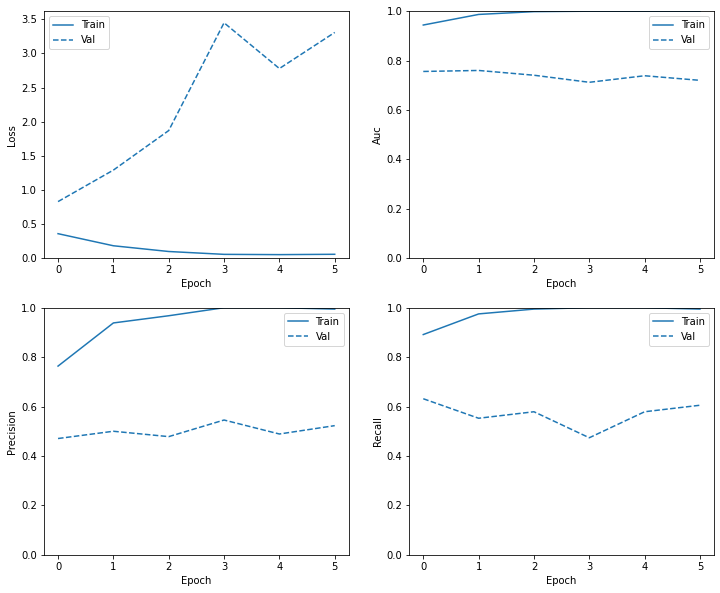

In [23]:
trainer.plot_metrics()